## Tecnológico de Costa Rica

### Autor: Jorge Andrés Brenes Alfaro

## Synthetic_PAHM

El código desarrollado a continuación está basado en [1]. La red diseñada es la encargada de reproducir el comportamiento de entrada y salida de una planta prototipo de péndulo amortiguado a hélice (PAHM). Este comportamiento es el modelado de la planta, es decir, se obtiene un modelado matemático teórico, el cual se transforma a espacio de estados y con teoría de control se determina la respuesta dinámica del sistema.

## Bibliotecas

In [ ]:
#!pip install wandb

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

import wandb
from wandb.keras import WandbCallback

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.backend import clear_session

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#wandb.login()
run = wandb.init(project = 'Virtual_PAHM',
                config = {
                    'epochs':1000,
                    'batch_size': 64,
                    'loss_function':'Adam',
                    'Architecture': 'RNN',
                    'dataset':'Propio'
                })

## 1. Definición del modelo
Se define el espacio de estados de la planta PAHM de la siguiente forma:
$$\dot{x}(t)=A*x(t)+Bu(t)\\
y(t)=C*x(t)$$
Donde:
- A, B y C son matrices.
- x(t) es el estado en el tiempo t.
- u(t) es la entrada externa.
- y(t) es la salida.

### 1.1 Función para simular la dinámica de la planta

In [2]:
def dinamica_modelo(A,B,C,cond_inicial,input_sequence, time_steps,muestreo):
    I = np.identity(A.shape[0])
    Ad = inv(I - muestreo*A)
    Bd = Ad*muestreo*B
    Xd = np.zeros(shape=(A.shape[0],time_steps + 1)) # # Vectores de 2 x 201 / X en tiempo discreto
    Yd = np.zeros(shape=(C.shape[0],time_steps + 1)) # # Vectores de 2 x 201 / Salida en tiempo discreto
    
    for i in range(0,time_steps):
        if i==0:
            Xd[:,[i]] = cond_inicial
            Yd[:,[i]] = C*cond_inicial
            x = Ad*cond_inicial + Bd*input_sequence[i]
        else:
            Xd[:,[i]] = x
            Yd[:,[i]] = C*x
            x = Ad*x + Bd*input_sequence[i]
            
    Xd[:,[-1]] = x
    Yd[:,[-1]] = C*x
    return Xd, Yd

## Función Escalón y rampa

In [3]:
# ********************************** Step Function **********************************#
def step_function(A,t):
    u = (t >= 0)*A
    return u

# ********************************** Ramp Function **********************************#
def ramp_function(A,t):
    r = t*step_function(A,t)
    return r

### 1.2 Definición del modelo en tiempo continuo

Text(0.5, 0, 'Time (ms)')

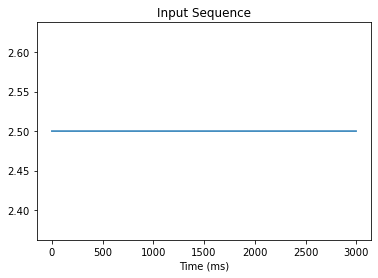

In [4]:
A = np.matrix([[0, 1],[-0.9413, -0.149]])
B = np.matrix([[0],[0.149]])
C = np.matrix([[1, 0]])

tiempo = 3000
sampling = 0.02  # Tiempo de muestreo
input_seq_train = np.random.rand(tiempo,1) # Secuencia de entrada para la simulación
                                           # Es aleatoria para que sea rica en información

x0_train = np.random.rand(2,1) # Condición inicial
input_seq = step_function(2.5,np.arange(0,tiempo)) # Escalón
#input_seq = ramp_function(2.5,np.arange(0,tiempo))

plt.plot(np.arange(0,tiempo),input_seq)
plt.title('Input Sequence')
plt.xlabel('Time (ms)')

### 1.3 Conversión a tiempo discreto y dinámica de la planta

Text(0.5, 1.0, 'Respuesta al escalón')

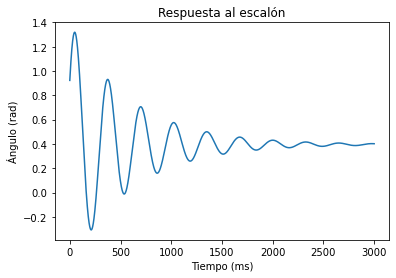

In [5]:
# Dinámica de la planta
state, output_train = dinamica_modelo(A,B,C,x0_train,input_seq,tiempo,sampling)  

plt.plot(output_train[0])
plt.xlabel('Tiempo (ms)')
plt.ylabel('Ángulo (rad)')
plt.title('Respuesta al escalón')

## 2. Creación de datos

Se replica el mismo método para crear datos de entrenamiento, validación y prueba. La diferencia radica en que se hace diferentes secuencias de entrada y condiciones iniciales de planta

### 2.1 Datos de entrenamiento

In [6]:
train_label = np.reshape(output_train.T,(1,output_train.T.shape[0],1)) # Salida para el entrenamiento

input_seq_train = np.reshape(input_seq_train,(input_seq_train.shape[0],1)) # El tamaño no cambia, ¿por qué cambian los valores?
tmp_train = np.concatenate((input_seq_train, np.zeros(shape=(input_seq_train.shape[0],1))), axis=1)
tmp_train = np.concatenate((x0_train.T,tmp_train), axis=0)
train_data = np.reshape(tmp_train, (1,tmp_train.shape[0],tmp_train.shape[1])) # Entrada para el entrenamiento

### 2.2 Datos de validación

In [7]:
input_seq_val = np.random.rand(tiempo,1)
x0_val = np.random.rand(2,1)

state_val,output_val = dinamica_modelo(A,B,C,x0_val,input_seq_val,tiempo,sampling)
val_label = np.reshape(output_val.T,(1,output_val.T.shape[0],1)) # Salida de datos de validación

input_seq_val = np.reshape(input_seq_val,(input_seq_val.shape[0],1))
tmp_val = np.concatenate((input_seq_val, np.zeros(shape=(input_seq_val.shape[0],1))), axis=1)
tmp_val = np.concatenate((x0_val.T,tmp_val), axis=0)
val_data = np.reshape(tmp_val, (1,tmp_val.shape[0],tmp_val.shape[1])) # Entrada para datos de validación

### 2.3 Datos de prueba

In [8]:
input_seq_test = np.random.rand(tiempo,1)
x0_test = np.random.rand(2,1)

state_test,output_test = dinamica_modelo(A,B,C,x0_test,input_seq_test,tiempo,sampling)
test_label = np.reshape(output_test.T,(1,output_test.T.shape[0],1)) # Salida de datos de prueba

input_seq_test = np.reshape(input_seq_test,(input_seq_test.shape[0],1))
tmp_test = np.concatenate((input_seq_test, np.zeros(shape=(input_seq_test.shape[0],1))), axis=1)
tmp_test = np.concatenate((x0_test.T,tmp_test), axis=0)
test_data = np.reshape(tmp_test, (1,tmp_test.shape[0],tmp_test.shape[1])) # Entrada para datos de validación

## 3. Creación de la red neuronal

### 3.1 Definición del modelo

In [9]:
clear_session()

model = Sequential()
#model.add(SimpleRNN(32, input_shape=(train_data.shape[1],train_data.shape[2]),return_sequences=True))
model.add(GRU(64, input_shape=(train_data.shape[1],train_data.shape[2]),return_sequences=True))
#model.add(LSTM(32, input_shape=(train_data.shape[1],train_data.shape[2]),return_sequences=True))
#model.add(Dense(1))
model.add(TimeDistributed(Dense(1)))  #there is no difference between this and model.add(Dense(1))...
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 3001, 64)          13056     
_________________________________________________________________
time_distributed (TimeDistri (None, 3001, 1)           65        
Total params: 13,121
Trainable params: 13,121
Non-trainable params: 0
_________________________________________________________________


### 3.2 Entrenamiento de la red

In [11]:
history = model.fit(train_data, train_label , 
                  epochs=2000, batch_size=8, 
                  validation_data=(val_data,val_label),verbose=2)#, callbacks=[WandbCallback()])

#model.save('PAHM_Synthetic_Model', save_format="h5")

# use the test data to predict the model response
testPredict = model.predict(test_data)

Epoch 1/2000
1/1 - 2s - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0910 - val_mse: 0.0910
Epoch 2/2000
1/1 - 2s - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0916 - val_mse: 0.0916
Epoch 3/2000
1/1 - 2s - loss: 0.0579 - mse: 0.0579 - val_loss: 0.0928 - val_mse: 0.0928
Epoch 4/2000
1/1 - 2s - loss: 0.0578 - mse: 0.0578 - val_loss: 0.0943 - val_mse: 0.0943
Epoch 5/2000
1/1 - 2s - loss: 0.0575 - mse: 0.0575 - val_loss: 0.0963 - val_mse: 0.0963
Epoch 6/2000
1/1 - 2s - loss: 0.0572 - mse: 0.0572 - val_loss: 0.0986 - val_mse: 0.0986
Epoch 7/2000
1/1 - 2s - loss: 0.0569 - mse: 0.0569 - val_loss: 0.1012 - val_mse: 0.1012
Epoch 8/2000
1/1 - 2s - loss: 0.0567 - mse: 0.0567 - val_loss: 0.1040 - val_mse: 0.1040
Epoch 9/2000
1/1 - 2s - loss: 0.0564 - mse: 0.0564 - val_loss: 0.1070 - val_mse: 0.1070
Epoch 10/2000
1/1 - 2s - loss: 0.0562 - mse: 0.0562 - val_loss: 0.1100 - val_mse: 0.1100
Epoch 11/2000
1/1 - 2s - loss: 0.0561 - mse: 0.0561 - val_loss: 0.1130 - val_mse: 0.1130
Epoch 12/2000
1/1 - 2s - loss:

1/1 - 2s - loss: 0.0544 - mse: 0.0544 - val_loss: 0.1172 - val_mse: 0.1172
Epoch 94/2000
1/1 - 1s - loss: 0.0544 - mse: 0.0544 - val_loss: 0.1171 - val_mse: 0.1171
Epoch 95/2000
1/1 - 2s - loss: 0.0544 - mse: 0.0544 - val_loss: 0.1171 - val_mse: 0.1171
Epoch 96/2000
1/1 - 2s - loss: 0.0544 - mse: 0.0544 - val_loss: 0.1170 - val_mse: 0.1170
Epoch 97/2000
1/1 - 2s - loss: 0.0544 - mse: 0.0544 - val_loss: 0.1170 - val_mse: 0.1170
Epoch 98/2000
1/1 - 1s - loss: 0.0544 - mse: 0.0544 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 99/2000
1/1 - 1s - loss: 0.0544 - mse: 0.0544 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 100/2000
1/1 - 2s - loss: 0.0544 - mse: 0.0544 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 101/2000
1/1 - 2s - loss: 0.0543 - mse: 0.0543 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 102/2000
1/1 - 2s - loss: 0.0543 - mse: 0.0543 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 103/2000
1/1 - 2s - loss: 0.0543 - mse: 0.0543 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 104/2000
1/1 - 2s - loss:

Epoch 185/2000
1/1 - 2s - loss: 0.0536 - mse: 0.0536 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 186/2000
1/1 - 2s - loss: 0.0536 - mse: 0.0536 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 187/2000
1/1 - 2s - loss: 0.0536 - mse: 0.0536 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 188/2000
1/1 - 2s - loss: 0.0536 - mse: 0.0536 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 189/2000
1/1 - 2s - loss: 0.0536 - mse: 0.0536 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 190/2000
1/1 - 2s - loss: 0.0536 - mse: 0.0536 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 191/2000
1/1 - 2s - loss: 0.0536 - mse: 0.0536 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 192/2000
1/1 - 2s - loss: 0.0536 - mse: 0.0536 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 193/2000
1/1 - 2s - loss: 0.0536 - mse: 0.0536 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 194/2000
1/1 - 2s - loss: 0.0536 - mse: 0.0536 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 195/2000
1/1 - 2s - loss: 0.0536 - mse: 0.0536 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 196/

1/1 - 2s - loss: 0.0532 - mse: 0.0532 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 277/2000
1/1 - 2s - loss: 0.0531 - mse: 0.0531 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 278/2000
1/1 - 2s - loss: 0.0531 - mse: 0.0531 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 279/2000
1/1 - 1s - loss: 0.0531 - mse: 0.0531 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 280/2000
1/1 - 1s - loss: 0.0531 - mse: 0.0531 - val_loss: 0.1169 - val_mse: 0.1169
Epoch 281/2000
1/1 - 1s - loss: 0.0531 - mse: 0.0531 - val_loss: 0.1168 - val_mse: 0.1168
Epoch 282/2000
1/1 - 2s - loss: 0.0531 - mse: 0.0531 - val_loss: 0.1168 - val_mse: 0.1168
Epoch 283/2000
1/1 - 1s - loss: 0.0531 - mse: 0.0531 - val_loss: 0.1168 - val_mse: 0.1168
Epoch 284/2000
1/1 - 1s - loss: 0.0531 - mse: 0.0531 - val_loss: 0.1168 - val_mse: 0.1168
Epoch 285/2000
1/1 - 2s - loss: 0.0531 - mse: 0.0531 - val_loss: 0.1168 - val_mse: 0.1168
Epoch 286/2000
1/1 - 1s - loss: 0.0531 - mse: 0.0531 - val_loss: 0.1168 - val_mse: 0.1168
Epoch 287/2000
1/1 - 1s -

Epoch 368/2000
1/1 - 1s - loss: 0.0502 - mse: 0.0502 - val_loss: 0.1162 - val_mse: 0.1162
Epoch 369/2000
1/1 - 1s - loss: 0.0500 - mse: 0.0500 - val_loss: 0.1162 - val_mse: 0.1162
Epoch 370/2000
1/1 - 1s - loss: 0.0498 - mse: 0.0498 - val_loss: 0.1162 - val_mse: 0.1162
Epoch 371/2000
1/1 - 1s - loss: 0.0496 - mse: 0.0496 - val_loss: 0.1161 - val_mse: 0.1161
Epoch 372/2000
1/1 - 1s - loss: 0.0494 - mse: 0.0494 - val_loss: 0.1161 - val_mse: 0.1161
Epoch 373/2000
1/1 - 1s - loss: 0.0492 - mse: 0.0492 - val_loss: 0.1160 - val_mse: 0.1160
Epoch 374/2000
1/1 - 1s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.1160 - val_mse: 0.1160
Epoch 375/2000
1/1 - 1s - loss: 0.0486 - mse: 0.0486 - val_loss: 0.1159 - val_mse: 0.1159
Epoch 376/2000
1/1 - 1s - loss: 0.0482 - mse: 0.0482 - val_loss: 0.1159 - val_mse: 0.1159
Epoch 377/2000
1/1 - 1s - loss: 0.0478 - mse: 0.0478 - val_loss: 0.1158 - val_mse: 0.1158
Epoch 378/2000
1/1 - 1s - loss: 0.0473 - mse: 0.0473 - val_loss: 0.1157 - val_mse: 0.1157
Epoch 379/

1/1 - 1s - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0988 - val_mse: 0.0988
Epoch 460/2000
1/1 - 1s - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0988 - val_mse: 0.0988
Epoch 461/2000
1/1 - 1s - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0987 - val_mse: 0.0987
Epoch 462/2000
1/1 - 1s - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0984 - val_mse: 0.0984
Epoch 463/2000
1/1 - 1s - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0981 - val_mse: 0.0981
Epoch 464/2000
1/1 - 1s - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0978 - val_mse: 0.0978
Epoch 465/2000
1/1 - 1s - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0978 - val_mse: 0.0978
Epoch 466/2000
1/1 - 1s - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0981 - val_mse: 0.0981
Epoch 467/2000
1/1 - 1s - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0984 - val_mse: 0.0984
Epoch 468/2000
1/1 - 1s - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0986 - val_mse: 0.0986
Epoch 469/2000
1/1 - 1s - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0987 - val_mse: 0.0987
Epoch 470/2000
1/1 - 1s -

Epoch 551/2000
1/1 - 1s - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0989 - val_mse: 0.0989
Epoch 552/2000
1/1 - 1s - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0989 - val_mse: 0.0989
Epoch 553/2000
1/1 - 1s - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0989 - val_mse: 0.0989
Epoch 554/2000
1/1 - 1s - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0989 - val_mse: 0.0989
Epoch 555/2000
1/1 - 1s - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0989 - val_mse: 0.0989
Epoch 556/2000
1/1 - 1s - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0989 - val_mse: 0.0989
Epoch 557/2000
1/1 - 1s - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0989 - val_mse: 0.0989
Epoch 558/2000
1/1 - 1s - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0989 - val_mse: 0.0989
Epoch 559/2000
1/1 - 1s - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0989 - val_mse: 0.0989
Epoch 560/2000
1/1 - 1s - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0989 - val_mse: 0.0989
Epoch 561/2000
1/1 - 1s - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0989 - val_mse: 0.0989
Epoch 562/

1/1 - 1s - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0990 - val_mse: 0.0990
Epoch 643/2000
1/1 - 1s - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0990 - val_mse: 0.0990
Epoch 644/2000
1/1 - 1s - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0990 - val_mse: 0.0990
Epoch 645/2000
1/1 - 1s - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0990 - val_mse: 0.0990
Epoch 646/2000
1/1 - 1s - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0990 - val_mse: 0.0990
Epoch 647/2000
1/1 - 1s - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0990 - val_mse: 0.0990
Epoch 648/2000
1/1 - 1s - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0990 - val_mse: 0.0990
Epoch 649/2000
1/1 - 1s - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0990 - val_mse: 0.0990
Epoch 650/2000
1/1 - 1s - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0990 - val_mse: 0.0990
Epoch 651/2000
1/1 - 1s - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0990 - val_mse: 0.0990
Epoch 652/2000
1/1 - 1s - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0990 - val_mse: 0.0990
Epoch 653/2000
1/1 - 1s -

Epoch 734/2000
1/1 - 1s - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0904 - val_mse: 0.0904
Epoch 735/2000
1/1 - 1s - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0963 - val_mse: 0.0963
Epoch 736/2000
1/1 - 1s - loss: 0.0045 - mse: 0.0045 - val_loss: 0.1114 - val_mse: 0.1114
Epoch 737/2000
1/1 - 1s - loss: 0.0074 - mse: 0.0074 - val_loss: 0.1170 - val_mse: 0.1170
Epoch 738/2000
1/1 - 1s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.1186 - val_mse: 0.1186
Epoch 739/2000
1/1 - 1s - loss: 0.0065 - mse: 0.0065 - val_loss: 0.1192 - val_mse: 0.1192
Epoch 740/2000
1/1 - 1s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.1207 - val_mse: 0.1207
Epoch 741/2000
1/1 - 1s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.1089 - val_mse: 0.1089
Epoch 742/2000
1/1 - 1s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0978 - val_mse: 0.0978
Epoch 743/2000
1/1 - 1s - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0950 - val_mse: 0.0950
Epoch 744/2000
1/1 - 1s - loss: 0.0030 - mse: 0.0030 - val_loss: 0.1010 - val_mse: 0.1010
Epoch 745/

Epoch 822/2000
1/1 - 1s - loss: 3.9823e-04 - mse: 3.9823e-04 - val_loss: 0.1080 - val_mse: 0.1080
Epoch 823/2000
1/1 - 1s - loss: 3.9281e-04 - mse: 3.9281e-04 - val_loss: 0.1081 - val_mse: 0.1081
Epoch 824/2000
1/1 - 1s - loss: 3.8640e-04 - mse: 3.8640e-04 - val_loss: 0.1080 - val_mse: 0.1080
Epoch 825/2000
1/1 - 1s - loss: 3.8105e-04 - mse: 3.8105e-04 - val_loss: 0.1078 - val_mse: 0.1078
Epoch 826/2000
1/1 - 1s - loss: 3.7706e-04 - mse: 3.7706e-04 - val_loss: 0.1079 - val_mse: 0.1079
Epoch 827/2000
1/1 - 1s - loss: 3.7290e-04 - mse: 3.7290e-04 - val_loss: 0.1078 - val_mse: 0.1078
Epoch 828/2000
1/1 - 1s - loss: 3.6777e-04 - mse: 3.6777e-04 - val_loss: 0.1080 - val_mse: 0.1080
Epoch 829/2000
1/1 - 1s - loss: 3.6268e-04 - mse: 3.6268e-04 - val_loss: 0.1081 - val_mse: 0.1081
Epoch 830/2000
1/1 - 1s - loss: 3.5854e-04 - mse: 3.5854e-04 - val_loss: 0.1081 - val_mse: 0.1081
Epoch 831/2000
1/1 - 1s - loss: 3.5497e-04 - mse: 3.5497e-04 - val_loss: 0.1083 - val_mse: 0.1083
Epoch 832/2000
1/1 -

Epoch 906/2000
1/1 - 1s - loss: 2.1444e-04 - mse: 2.1444e-04 - val_loss: 0.1090 - val_mse: 0.1090
Epoch 907/2000
1/1 - 1s - loss: 2.1365e-04 - mse: 2.1365e-04 - val_loss: 0.1091 - val_mse: 0.1091
Epoch 908/2000
1/1 - 1s - loss: 2.1291e-04 - mse: 2.1291e-04 - val_loss: 0.1090 - val_mse: 0.1090
Epoch 909/2000
1/1 - 1s - loss: 2.1220e-04 - mse: 2.1220e-04 - val_loss: 0.1091 - val_mse: 0.1091
Epoch 910/2000
1/1 - 1s - loss: 2.1157e-04 - mse: 2.1157e-04 - val_loss: 0.1090 - val_mse: 0.1090
Epoch 911/2000
1/1 - 1s - loss: 2.1103e-04 - mse: 2.1103e-04 - val_loss: 0.1091 - val_mse: 0.1091
Epoch 912/2000
1/1 - 1s - loss: 2.1064e-04 - mse: 2.1064e-04 - val_loss: 0.1090 - val_mse: 0.1090
Epoch 913/2000
1/1 - 1s - loss: 2.1049e-04 - mse: 2.1049e-04 - val_loss: 0.1091 - val_mse: 0.1091
Epoch 914/2000
1/1 - 1s - loss: 2.1080e-04 - mse: 2.1080e-04 - val_loss: 0.1090 - val_mse: 0.1090
Epoch 915/2000
1/1 - 1s - loss: 2.1172e-04 - mse: 2.1172e-04 - val_loss: 0.1092 - val_mse: 0.1092
Epoch 916/2000
1/1 -

Epoch 990/2000
1/1 - 1s - loss: 2.4496e-04 - mse: 2.4496e-04 - val_loss: 0.1089 - val_mse: 0.1089
Epoch 991/2000
1/1 - 1s - loss: 2.6680e-04 - mse: 2.6680e-04 - val_loss: 0.1098 - val_mse: 0.1098
Epoch 992/2000
1/1 - 1s - loss: 3.1442e-04 - mse: 3.1442e-04 - val_loss: 0.1087 - val_mse: 0.1087
Epoch 993/2000
1/1 - 1s - loss: 3.3930e-04 - mse: 3.3930e-04 - val_loss: 0.1099 - val_mse: 0.1099
Epoch 994/2000
1/1 - 1s - loss: 4.0423e-04 - mse: 4.0423e-04 - val_loss: 0.1086 - val_mse: 0.1086
Epoch 995/2000
1/1 - 1s - loss: 3.9865e-04 - mse: 3.9865e-04 - val_loss: 0.1099 - val_mse: 0.1099
Epoch 996/2000
1/1 - 1s - loss: 4.3329e-04 - mse: 4.3329e-04 - val_loss: 0.1087 - val_mse: 0.1087
Epoch 997/2000
1/1 - 1s - loss: 3.7289e-04 - mse: 3.7289e-04 - val_loss: 0.1098 - val_mse: 0.1098
Epoch 998/2000
1/1 - 1s - loss: 3.5017e-04 - mse: 3.5017e-04 - val_loss: 0.1088 - val_mse: 0.1088
Epoch 999/2000
1/1 - 1s - loss: 2.8560e-04 - mse: 2.8560e-04 - val_loss: 0.1097 - val_mse: 0.1097
Epoch 1000/2000
1/1 

Epoch 1073/2000
1/1 - 1s - loss: 2.5002e-04 - mse: 2.5002e-04 - val_loss: 0.1099 - val_mse: 0.1099
Epoch 1074/2000
1/1 - 1s - loss: 2.9201e-04 - mse: 2.9201e-04 - val_loss: 0.1088 - val_mse: 0.1088
Epoch 1075/2000
1/1 - 1s - loss: 3.0257e-04 - mse: 3.0257e-04 - val_loss: 0.1099 - val_mse: 0.1099
Epoch 1076/2000
1/1 - 1s - loss: 3.3132e-04 - mse: 3.3132e-04 - val_loss: 0.1088 - val_mse: 0.1088
Epoch 1077/2000
1/1 - 1s - loss: 3.0498e-04 - mse: 3.0498e-04 - val_loss: 0.1099 - val_mse: 0.1099
Epoch 1078/2000
1/1 - 1s - loss: 3.0307e-04 - mse: 3.0307e-04 - val_loss: 0.1089 - val_mse: 0.1089
Epoch 1079/2000
1/1 - 1s - loss: 2.6522e-04 - mse: 2.6522e-04 - val_loss: 0.1098 - val_mse: 0.1098
Epoch 1080/2000
1/1 - 1s - loss: 2.4705e-04 - mse: 2.4705e-04 - val_loss: 0.1090 - val_mse: 0.1090
Epoch 1081/2000
1/1 - 1s - loss: 2.1428e-04 - mse: 2.1428e-04 - val_loss: 0.1097 - val_mse: 0.1097
Epoch 1082/2000
1/1 - 1s - loss: 1.9595e-04 - mse: 1.9595e-04 - val_loss: 0.1091 - val_mse: 0.1091
Epoch 1083

Epoch 1156/2000
1/1 - 1s - loss: 1.5164e-04 - mse: 1.5164e-04 - val_loss: 0.1096 - val_mse: 0.1096
Epoch 1157/2000
1/1 - 1s - loss: 1.5831e-04 - mse: 1.5831e-04 - val_loss: 0.1091 - val_mse: 0.1091
Epoch 1158/2000
1/1 - 1s - loss: 1.6648e-04 - mse: 1.6648e-04 - val_loss: 0.1097 - val_mse: 0.1097
Epoch 1159/2000
1/1 - 1s - loss: 1.8174e-04 - mse: 1.8174e-04 - val_loss: 0.1090 - val_mse: 0.1090
Epoch 1160/2000
1/1 - 1s - loss: 1.9838e-04 - mse: 1.9838e-04 - val_loss: 0.1098 - val_mse: 0.1098
Epoch 1161/2000
1/1 - 1s - loss: 2.3194e-04 - mse: 2.3194e-04 - val_loss: 0.1089 - val_mse: 0.1089
Epoch 1162/2000
1/1 - 1s - loss: 2.5998e-04 - mse: 2.5998e-04 - val_loss: 0.1099 - val_mse: 0.1099
Epoch 1163/2000
1/1 - 1s - loss: 3.2150e-04 - mse: 3.2150e-04 - val_loss: 0.1087 - val_mse: 0.1087
Epoch 1164/2000
1/1 - 1s - loss: 3.4551e-04 - mse: 3.4551e-04 - val_loss: 0.1101 - val_mse: 0.1101
Epoch 1165/2000
1/1 - 1s - loss: 4.1501e-04 - mse: 4.1501e-04 - val_loss: 0.1086 - val_mse: 0.1086
Epoch 1166

Epoch 1239/2000
1/1 - 1s - loss: 1.3585e-04 - mse: 1.3585e-04 - val_loss: 0.1093 - val_mse: 0.1093
Epoch 1240/2000
1/1 - 1s - loss: 1.4151e-04 - mse: 1.4151e-04 - val_loss: 0.1096 - val_mse: 0.1096
Epoch 1241/2000
1/1 - 1s - loss: 1.4990e-04 - mse: 1.4990e-04 - val_loss: 0.1092 - val_mse: 0.1092
Epoch 1242/2000
1/1 - 1s - loss: 1.5872e-04 - mse: 1.5872e-04 - val_loss: 0.1097 - val_mse: 0.1097
Epoch 1243/2000
1/1 - 1s - loss: 1.7306e-04 - mse: 1.7306e-04 - val_loss: 0.1091 - val_mse: 0.1091
Epoch 1244/2000
1/1 - 1s - loss: 1.8557e-04 - mse: 1.8557e-04 - val_loss: 0.1098 - val_mse: 0.1098
Epoch 1245/2000
1/1 - 1s - loss: 2.0891e-04 - mse: 2.0891e-04 - val_loss: 0.1089 - val_mse: 0.1089
Epoch 1246/2000
1/1 - 1s - loss: 2.2298e-04 - mse: 2.2298e-04 - val_loss: 0.1099 - val_mse: 0.1099
Epoch 1247/2000
1/1 - 1s - loss: 2.5440e-04 - mse: 2.5440e-04 - val_loss: 0.1089 - val_mse: 0.1089
Epoch 1248/2000
1/1 - 1s - loss: 2.6242e-04 - mse: 2.6242e-04 - val_loss: 0.1099 - val_mse: 0.1099
Epoch 1249

Epoch 1322/2000
1/1 - 1s - loss: 1.2751e-04 - mse: 1.2751e-04 - val_loss: 0.1093 - val_mse: 0.1093
Epoch 1323/2000
1/1 - 1s - loss: 1.2355e-04 - mse: 1.2355e-04 - val_loss: 0.1095 - val_mse: 0.1095
Epoch 1324/2000
1/1 - 1s - loss: 1.2129e-04 - mse: 1.2129e-04 - val_loss: 0.1094 - val_mse: 0.1094
Epoch 1325/2000
1/1 - 1s - loss: 1.2003e-04 - mse: 1.2003e-04 - val_loss: 0.1094 - val_mse: 0.1094
Epoch 1326/2000
1/1 - 1s - loss: 1.1947e-04 - mse: 1.1947e-04 - val_loss: 0.1094 - val_mse: 0.1094
Epoch 1327/2000
1/1 - 1s - loss: 1.1940e-04 - mse: 1.1940e-04 - val_loss: 0.1094 - val_mse: 0.1094
Epoch 1328/2000
1/1 - 1s - loss: 1.1969e-04 - mse: 1.1969e-04 - val_loss: 0.1095 - val_mse: 0.1095
Epoch 1329/2000
1/1 - 1s - loss: 1.2029e-04 - mse: 1.2029e-04 - val_loss: 0.1093 - val_mse: 0.1093
Epoch 1330/2000
1/1 - 1s - loss: 1.2120e-04 - mse: 1.2120e-04 - val_loss: 0.1095 - val_mse: 0.1095
Epoch 1331/2000
1/1 - 1s - loss: 1.2256e-04 - mse: 1.2256e-04 - val_loss: 0.1093 - val_mse: 0.1093
Epoch 1332

Epoch 1405/2000
1/1 - 1s - loss: 1.1443e-04 - mse: 1.1443e-04 - val_loss: 0.1095 - val_mse: 0.1095
Epoch 1406/2000
1/1 - 1s - loss: 1.1585e-04 - mse: 1.1585e-04 - val_loss: 0.1093 - val_mse: 0.1093
Epoch 1407/2000
1/1 - 1s - loss: 1.1817e-04 - mse: 1.1817e-04 - val_loss: 0.1096 - val_mse: 0.1096
Epoch 1408/2000
1/1 - 1s - loss: 1.2254e-04 - mse: 1.2254e-04 - val_loss: 0.1092 - val_mse: 0.1092
Epoch 1409/2000
1/1 - 1s - loss: 1.2941e-04 - mse: 1.2941e-04 - val_loss: 0.1097 - val_mse: 0.1097
Epoch 1410/2000
1/1 - 1s - loss: 1.4284e-04 - mse: 1.4284e-04 - val_loss: 0.1091 - val_mse: 0.1091
Epoch 1411/2000
1/1 - 1s - loss: 1.6230e-04 - mse: 1.6230e-04 - val_loss: 0.1099 - val_mse: 0.1099
Epoch 1412/2000
1/1 - 1s - loss: 2.0238e-04 - mse: 2.0238e-04 - val_loss: 0.1089 - val_mse: 0.1089
Epoch 1413/2000
1/1 - 1s - loss: 2.4987e-04 - mse: 2.4987e-04 - val_loss: 0.1101 - val_mse: 0.1101
Epoch 1414/2000
1/1 - 1s - loss: 3.5215e-04 - mse: 3.5215e-04 - val_loss: 0.1086 - val_mse: 0.1086
Epoch 1415

Epoch 1488/2000
1/1 - 1s - loss: 1.4357e-04 - mse: 1.4357e-04 - val_loss: 0.1097 - val_mse: 0.1097
Epoch 1489/2000
1/1 - 1s - loss: 1.5914e-04 - mse: 1.5914e-04 - val_loss: 0.1090 - val_mse: 0.1090
Epoch 1490/2000
1/1 - 1s - loss: 1.7231e-04 - mse: 1.7231e-04 - val_loss: 0.1098 - val_mse: 0.1098
Epoch 1491/2000
1/1 - 1s - loss: 1.9770e-04 - mse: 1.9770e-04 - val_loss: 0.1089 - val_mse: 0.1089
Epoch 1492/2000
1/1 - 1s - loss: 2.1316e-04 - mse: 2.1316e-04 - val_loss: 0.1099 - val_mse: 0.1099
Epoch 1493/2000
1/1 - 1s - loss: 2.4781e-04 - mse: 2.4781e-04 - val_loss: 0.1088 - val_mse: 0.1088
Epoch 1494/2000
1/1 - 1s - loss: 2.5633e-04 - mse: 2.5633e-04 - val_loss: 0.1100 - val_mse: 0.1100
Epoch 1495/2000
1/1 - 1s - loss: 2.8863e-04 - mse: 2.8863e-04 - val_loss: 0.1087 - val_mse: 0.1087
Epoch 1496/2000
1/1 - 1s - loss: 2.7629e-04 - mse: 2.7629e-04 - val_loss: 0.1100 - val_mse: 0.1100
Epoch 1497/2000
1/1 - 1s - loss: 2.8813e-04 - mse: 2.8813e-04 - val_loss: 0.1088 - val_mse: 0.1088
Epoch 1498

Epoch 1571/2000
1/1 - 1s - loss: 1.0907e-04 - mse: 1.0907e-04 - val_loss: 0.1095 - val_mse: 0.1095
Epoch 1572/2000
1/1 - 1s - loss: 1.0795e-04 - mse: 1.0795e-04 - val_loss: 0.1093 - val_mse: 0.1093
Epoch 1573/2000
1/1 - 1s - loss: 1.0702e-04 - mse: 1.0702e-04 - val_loss: 0.1095 - val_mse: 0.1095
Epoch 1574/2000
1/1 - 1s - loss: 1.0679e-04 - mse: 1.0679e-04 - val_loss: 0.1093 - val_mse: 0.1093
Epoch 1575/2000
1/1 - 1s - loss: 1.0669e-04 - mse: 1.0669e-04 - val_loss: 0.1095 - val_mse: 0.1095
Epoch 1576/2000
1/1 - 1s - loss: 1.0726e-04 - mse: 1.0726e-04 - val_loss: 0.1092 - val_mse: 0.1092
Epoch 1577/2000
1/1 - 1s - loss: 1.0800e-04 - mse: 1.0800e-04 - val_loss: 0.1095 - val_mse: 0.1095
Epoch 1578/2000
1/1 - 1s - loss: 1.0965e-04 - mse: 1.0965e-04 - val_loss: 0.1092 - val_mse: 0.1092
Epoch 1579/2000
1/1 - 1s - loss: 1.1160e-04 - mse: 1.1160e-04 - val_loss: 0.1096 - val_mse: 0.1096
Epoch 1580/2000
1/1 - 1s - loss: 1.1523e-04 - mse: 1.1523e-04 - val_loss: 0.1092 - val_mse: 0.1092
Epoch 1581

Epoch 1654/2000
1/1 - 1s - loss: 3.2549e-04 - mse: 3.2549e-04 - val_loss: 0.1086 - val_mse: 0.1086
Epoch 1655/2000
1/1 - 1s - loss: 2.9325e-04 - mse: 2.9325e-04 - val_loss: 0.1100 - val_mse: 0.1100
Epoch 1656/2000
1/1 - 1s - loss: 2.8758e-04 - mse: 2.8758e-04 - val_loss: 0.1088 - val_mse: 0.1088
Epoch 1657/2000
1/1 - 1s - loss: 2.3781e-04 - mse: 2.3781e-04 - val_loss: 0.1099 - val_mse: 0.1099
Epoch 1658/2000
1/1 - 1s - loss: 2.1284e-04 - mse: 2.1284e-04 - val_loss: 0.1089 - val_mse: 0.1089
Epoch 1659/2000
1/1 - 1s - loss: 1.7392e-04 - mse: 1.7392e-04 - val_loss: 0.1098 - val_mse: 0.1098
Epoch 1660/2000
1/1 - 1s - loss: 1.5186e-04 - mse: 1.5186e-04 - val_loss: 0.1091 - val_mse: 0.1091
Epoch 1661/2000
1/1 - 1s - loss: 1.3004e-04 - mse: 1.3004e-04 - val_loss: 0.1096 - val_mse: 0.1096
Epoch 1662/2000
1/1 - 1s - loss: 1.1711e-04 - mse: 1.1711e-04 - val_loss: 0.1092 - val_mse: 0.1092
Epoch 1663/2000
1/1 - 1s - loss: 1.0710e-04 - mse: 1.0710e-04 - val_loss: 0.1095 - val_mse: 0.1095
Epoch 1664

Epoch 1737/2000
1/1 - 1s - loss: 1.0344e-04 - mse: 1.0344e-04 - val_loss: 0.1091 - val_mse: 0.1091
Epoch 1738/2000
1/1 - 1s - loss: 1.0818e-04 - mse: 1.0818e-04 - val_loss: 0.1096 - val_mse: 0.1096
Epoch 1739/2000
1/1 - 1s - loss: 1.1575e-04 - mse: 1.1575e-04 - val_loss: 0.1090 - val_mse: 0.1090
Epoch 1740/2000
1/1 - 1s - loss: 1.2389e-04 - mse: 1.2389e-04 - val_loss: 0.1097 - val_mse: 0.1097
Epoch 1741/2000
1/1 - 1s - loss: 1.3797e-04 - mse: 1.3797e-04 - val_loss: 0.1089 - val_mse: 0.1089
Epoch 1742/2000
1/1 - 1s - loss: 1.5141e-04 - mse: 1.5141e-04 - val_loss: 0.1098 - val_mse: 0.1098
Epoch 1743/2000
1/1 - 1s - loss: 1.7636e-04 - mse: 1.7636e-04 - val_loss: 0.1088 - val_mse: 0.1088
Epoch 1744/2000
1/1 - 1s - loss: 1.9510e-04 - mse: 1.9510e-04 - val_loss: 0.1099 - val_mse: 0.1099
Epoch 1745/2000
1/1 - 1s - loss: 2.3295e-04 - mse: 2.3295e-04 - val_loss: 0.1087 - val_mse: 0.1087
Epoch 1746/2000
1/1 - 1s - loss: 2.4879e-04 - mse: 2.4879e-04 - val_loss: 0.1100 - val_mse: 0.1100
Epoch 1747

Epoch 1820/2000
1/1 - 1s - loss: 1.0759e-04 - mse: 1.0759e-04 - val_loss: 0.1095 - val_mse: 0.1095
Epoch 1821/2000
1/1 - 1s - loss: 1.0001e-04 - mse: 1.0001e-04 - val_loss: 0.1092 - val_mse: 0.1092
Epoch 1822/2000
1/1 - 1s - loss: 9.4239e-05 - mse: 9.4239e-05 - val_loss: 0.1095 - val_mse: 0.1095
Epoch 1823/2000
1/1 - 1s - loss: 9.0660e-05 - mse: 9.0660e-05 - val_loss: 0.1093 - val_mse: 0.1093
Epoch 1824/2000
1/1 - 1s - loss: 8.8265e-05 - mse: 8.8265e-05 - val_loss: 0.1094 - val_mse: 0.1094
Epoch 1825/2000
1/1 - 1s - loss: 8.6853e-05 - mse: 8.6853e-05 - val_loss: 0.1093 - val_mse: 0.1093
Epoch 1826/2000
1/1 - 1s - loss: 8.6063e-05 - mse: 8.6063e-05 - val_loss: 0.1093 - val_mse: 0.1093
Epoch 1827/2000
1/1 - 1s - loss: 8.5712e-05 - mse: 8.5712e-05 - val_loss: 0.1093 - val_mse: 0.1093
Epoch 1828/2000
1/1 - 1s - loss: 8.5663e-05 - mse: 8.5663e-05 - val_loss: 0.1093 - val_mse: 0.1093
Epoch 1829/2000
1/1 - 1s - loss: 8.5842e-05 - mse: 8.5842e-05 - val_loss: 0.1094 - val_mse: 0.1094
Epoch 1830

Epoch 1903/2000
1/1 - 1s - loss: 1.1292e-04 - mse: 1.1292e-04 - val_loss: 0.1089 - val_mse: 0.1089
Epoch 1904/2000
1/1 - 1s - loss: 1.2471e-04 - mse: 1.2471e-04 - val_loss: 0.1097 - val_mse: 0.1097
Epoch 1905/2000
1/1 - 1s - loss: 1.4601e-04 - mse: 1.4601e-04 - val_loss: 0.1088 - val_mse: 0.1088
Epoch 1906/2000
1/1 - 1s - loss: 1.6807e-04 - mse: 1.6807e-04 - val_loss: 0.1099 - val_mse: 0.1099
Epoch 1907/2000
1/1 - 1s - loss: 2.0956e-04 - mse: 2.0956e-04 - val_loss: 0.1086 - val_mse: 0.1086
Epoch 1908/2000
1/1 - 1s - loss: 2.4083e-04 - mse: 2.4083e-04 - val_loss: 0.1101 - val_mse: 0.1101
Epoch 1909/2000
1/1 - 1s - loss: 3.0264e-04 - mse: 3.0264e-04 - val_loss: 0.1084 - val_mse: 0.1084
Epoch 1910/2000
1/1 - 1s - loss: 3.1944e-04 - mse: 3.1944e-04 - val_loss: 0.1101 - val_mse: 0.1101
Epoch 1911/2000
1/1 - 1s - loss: 3.6662e-04 - mse: 3.6662e-04 - val_loss: 0.1084 - val_mse: 0.1084
Epoch 1912/2000
1/1 - 1s - loss: 3.3183e-04 - mse: 3.3183e-04 - val_loss: 0.1101 - val_mse: 0.1101
Epoch 1913

Epoch 1986/2000
1/1 - 1s - loss: 7.8836e-05 - mse: 7.8836e-05 - val_loss: 0.1093 - val_mse: 0.1093
Epoch 1987/2000
1/1 - 1s - loss: 8.0534e-05 - mse: 8.0534e-05 - val_loss: 0.1091 - val_mse: 0.1091
Epoch 1988/2000
1/1 - 1s - loss: 8.3311e-05 - mse: 8.3311e-05 - val_loss: 0.1094 - val_mse: 0.1094
Epoch 1989/2000
1/1 - 1s - loss: 8.7239e-05 - mse: 8.7239e-05 - val_loss: 0.1090 - val_mse: 0.1090
Epoch 1990/2000
1/1 - 1s - loss: 9.1849e-05 - mse: 9.1849e-05 - val_loss: 0.1095 - val_mse: 0.1095
Epoch 1991/2000
1/1 - 1s - loss: 9.8245e-05 - mse: 9.8245e-05 - val_loss: 0.1089 - val_mse: 0.1089
Epoch 1992/2000
1/1 - 1s - loss: 1.0492e-04 - mse: 1.0492e-04 - val_loss: 0.1095 - val_mse: 0.1095
Epoch 1993/2000
1/1 - 1s - loss: 1.1499e-04 - mse: 1.1499e-04 - val_loss: 0.1088 - val_mse: 0.1088
Epoch 1994/2000
1/1 - 1s - loss: 1.2429e-04 - mse: 1.2429e-04 - val_loss: 0.1096 - val_mse: 0.1096
Epoch 1995/2000
1/1 - 1s - loss: 1.3975e-04 - mse: 1.3975e-04 - val_loss: 0.1087 - val_mse: 0.1087
Epoch 1996

In [12]:
loss, accuracy = model.evaluate(test_data,test_label)
#wandb.log({'evaluate/accuracy': accuracy})
#wandb.run.finish()

1/1 [==============================] - 0s 97ms/step - loss: 0.1047 - mse: 0.1047


## 4. Plot the predicted and "true" output and plot training and validation losses

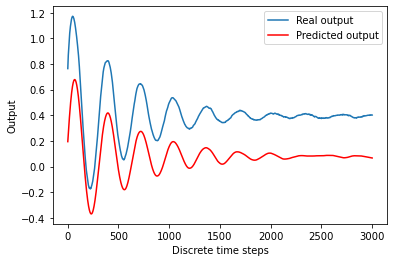

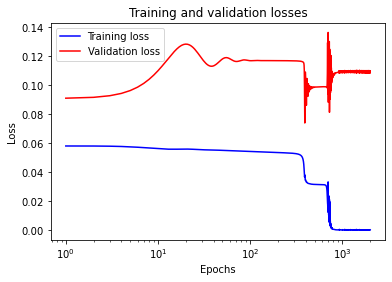

In [13]:
time_plot=range(1,tiempo+2)
plt.figure()
plt.plot(time_plot,testPredict[0,:,0], label='Real output')
plt.plot(time_plot,output_test[0,:],'r', label='Predicted output')
plt.xlabel('Discrete time steps')
plt.ylabel('Output')
plt.legend()
plt.show()

loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs, loss,'b', label='Training loss')
plt.plot(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
plt.legend()
plt.show()

## 5. Bibliografía
-H. Kapasi, 2022. "Modeling Non-Linear Dynamic Systems with Neural Networks", 2022. [En línea]. Disponible en: https://towardsdatascience.com/modeling-non-linear-dynamic-systems-with-neural-networks-f3761bc92649. [Accesado el 7 de marzo del 2022].